# An AS/AD-model for a closed economy in the short run

**This project analyzes the effects of shocks to a simple AS/AD-model for a closed economy in the short run. We use the model to analyze changes in taxes, government spending and monetary policy.**

Imports and set magics:

In [83]:
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import scipy.optimize as opt

plt.rcParams.update({"axes.grid":True,"grid.color":"darkblue","grid.alpha":"0.3","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 12})

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

from modelproject import *
model = AS_AD_model()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of modelproject failed: Traceback (most recent call last):
  File "/Users/ellenhojlund/anaconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/ellenhojlund/anaconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/ellenhojlund/anaconda3/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/ellenhojlund/projects-2024-william-ellen-og-lauge-4/modelproject/modelproject.py", line 85, in <module>
    plot_supply_shock(s=-0.5)
  File "/Users/ellenhojlund/projects-2024-william-ellen-og-lauge-4/modelproject/modelpr

# Model description

The model used in this project is a version of a closed economy AS/AD-model as outlined in "Introducing Advanced Macroeconomics - Growth and Business Cycles" by Peter Birch Sørensen & Hans Jørgen Whitta-Jacobsen.  

We use the following equations to describe our model: 

**1: IS-curve** - Market equilibrium with government spending and taxes.

$$
y_t-\bar{y} = \alpha_1 (g_t-\bar{g}) - \alpha_2(r_t-\bar{r})-\alpha_{3}(\tau_{t}-\overline{\tau})
$$

**2: Fischer Equation** - In ex-ante (modeled by expected inflation).

$$
r_t = i_t-\pi^{e}_{t+1}
$$

**3: Monetary policy rule** - The Taylor-Rule with stabilization wrt. both inflation and output

$$
i_t = \bar{r} + \pi^{e}_{t+1} + h(\pi_t - \pi^*) + b(y_t- \bar{y})
$$

**4: The SRAS curve** - This is derived from the expectations-augmented Phillips-curve. For given inflation expectations, there is a positive correlation between inflation and outputgap. 

$$
\pi_t = \pi_t^e + \gamma (y_t-\bar{y}) + s_t
$$


**5: Inflation expectations** - This equation shows that the agents have static inflation expectations, since they expect inflation in period t to be equal to observed inflation in the previous period. 

$$
\pi_t^e = \pi_{t-1}
$$

From the above equations, we can define the AD-curve and the AS-curve: 


The AD-curve combines equations 1, 2 and 3. Inserting 3 in 2:

$$
r_t = \bar{r} + \pi^{e}_{t+1} + h(\pi_t - \pi^*) + b(y_t- \bar{y})-\pi^{e}_{t+1}
$$
$$
r_t = \bar{r} + h(\pi_t - \pi^*) + b(y_t- \bar{y})
$$
Inserting in eq. 1:
$$
y_t-\bar{y} = \alpha_1 (g_t-\bar{g}) - \alpha_2(\bar{r} + h(\pi_t - \pi^*) + b(y_t- \bar{y})-\bar{r})-\alpha_{3}(\tau_{t}-\overline{\tau})
$$
$$
y_t-\bar{y} = \alpha_1 (g_t-\bar{g}) - \alpha_2(h(\pi_t - \pi^*) + b(y_t- \bar{y}))-\alpha_{3}(\tau_{t}-\overline{\tau})
$$
Isolating $y_t-\bar{y}$:
$$
y_t-\bar{y} = z-\alpha(\pi_t - \pi^*)
$$
where
$$
z = \frac{\alpha_1}{1+\alpha_2b}(g_t-\bar{g})-\frac{\alpha_3}{1+\alpha_2b}(\tau_t-\bar{\tau}), \alpha = \frac{\alpha_2 h}{1+\alpha_2b}
$$

The AS-curve is found by inserting equation 5 in 4:

$$
\pi_t = \pi_{t-1} + \gamma(y_t-\bar{y}) + s_t $$

## Analytical solution

We define our model in Python:

In [84]:
# Now you can call the methods of the class using the model instance
# For example, to call the `ad` method and print its output:
output = model.ad(y=100, y_bar=100, pi=2, pi_star=2, alpha=1, alpha_1=1, alpha_2=1, alpha_3=1, b=1, g=1, g_bar=1, h=1, tau=0.5, tau_bar=0.5)
print(output)

0.0


We calculate the Steady State Value:

In [85]:

y_bar = 100
pi_star = 2
alpha_1 = 1
alpha_2 = 1
alpha_3 = 1
b = 1
g = 1
g_bar = 1
h = 1
gamma = 0.5
tau = 0.5
tau_bar = 0.5


#Calculating steady state value assuming no supply shocks
steady_state = model.ss_func(pi_star, g, b, alpha_1, alpha_2, alpha_3, h, 0, y_bar, pi_star, gamma, tau, tau_bar)

#Printing the result
print("The steady state value is:", steady_state)

The steady state value is: 67.0


## Numerical solution

In this section, we look at the social loss of shocks to inflation and output. Social loss is minimized when the following function is minimized:

**Minimizing social loss function:**

$$ L_t = (\pi_t - \pi^*) + \alpha (y_t - \bar{y}) $$


Next, we find the optimal level of g and $\alpha_1$ that minimizes social loss:

In [86]:
pi = 0.02
b = 0.5

alpha2 = 1
alpha_3 = 1
h = 0.5
s = 0
y_bar = 100 
pi_star = 0.02
gamma = 0.5

# Defining the social loss function with fixed parameters
def social_loss(args):
    g, alpha_1 = args
    y = model.ss_func(pi_star, g, b, alpha_1, alpha_2, alpha_3, h, 0, y_bar, pi_star, gamma, tau, tau_bar)
    return (y_bar - y) ** 2 + (pi_star - pi) ** 2

# Initial values for the varying parameters
initial_g = 0.03
initial_alpha_1 = 1.5

# Optimizing the social loss function with respect to g and alpha_1 using the trust-constr method
optimal_par_gh = opt.minimize(social_loss, [initial_g, initial_alpha_1], method='trust-constr')

print("The optimal parameter values that minimize the social loss are:")
print("g:", optimal_par_gh.x[0])
print("alpha_1:", optimal_par_gh.x[1])

The optimal parameter values that minimize the social loss are:
g: 0.045006380976774
alpha_1: 2.621045736125542e-12


We now evaluate these parameter values to see whether they minimize the social loss. Afterwards, we calculate the optimal social loss and the minimal social loss. 

In [87]:
#Evaluating the social loss at the optimal parameter values
optimal_g = optimal_par_gh.x[0]
optimal_alpha_1 = optimal_par_gh.x[1]
optimal_social_loss = social_loss([optimal_g, optimal_alpha_1])

#Generating a range of parameter combinations
g_values = np.linspace(0, 0.1, 100)   #Generating 100 equally spaced values between 0 and 0.1 for parameter g
alpha_1_values = np.linspace(0, 3, 100)   #Generating 100 equally spaced values between 0 and 3 for parameter alpha_1
social_loss_values = np.zeros((100, 100))   #Creating a 100x100 array to store social loss values

#Calculating social loss for each parameter combination
for i, g in enumerate(g_values):
    for j, alpha_1 in enumerate(alpha_1_values):
        social_loss_values[i, j] = social_loss([g, alpha_1])   #Calculating social loss for each parameter combination

#Finding the minimum social loss and its corresponding parameter values
min_loss = np.min(social_loss_values)   #Finding the minimum social loss value from the array
min_loss_idx = np.unravel_index(np.argmin(social_loss_values), social_loss_values.shape)   #Finding the indices of the minimum loss value
min_loss_g = g_values[min_loss_idx[0]]   #Extracting the corresponding value of g for the minimum loss
min_loss_alpha_1 = alpha_1_values[min_loss_idx[1]]   #Extracting the corresponding value of alpha_1 for the minimum loss

#Compare the optimal social loss with the minimum social loss
if np.isclose(optimal_social_loss, min_loss):
    print("The optimal parameter values do indeed minimize the social loss function.")   #Text indicating that the optimal parameter values minimize the social loss function
else:
    print("The optimal parameter values may not minimize the social loss function.")   #Text indicating that they may not minimize the social loss function

#Printing the optimal social loss and the minimum social loss
print("Optimal Social Loss:", optimal_social_loss)   #Print the value of the optimal social loss
print("Minimum Social Loss:", min_loss)   #Print the value of the minimum social loss

The optimal parameter values do indeed minimize the social loss function.
Optimal Social Loss: 1.3559145408762797e-20
Minimum Social Loss: 0.0


Next, we check the convergence of social loss:

Current social loss: 4441.778177777779
Current social loss: 493.6049315792927
Current social loss: 6.950734503724935e-05
Current social loss: 1.0921029045300132e-13
Current social loss: 1.0921029045300132e-13
Current social loss: 1.3559145408762797e-20
Current social loss: 1.3559145408762797e-20
Current social loss: 1.3559145408762797e-20
Current social loss: 1.3559145408762797e-20
Current social loss: 1.3559145408762797e-20
Current social loss: 1.3559145408762797e-20
Current social loss: 1.3559145408762797e-20
Current social loss: 1.3559145408762797e-20
Current social loss: 1.3559145408762797e-20
The optimization has converged.


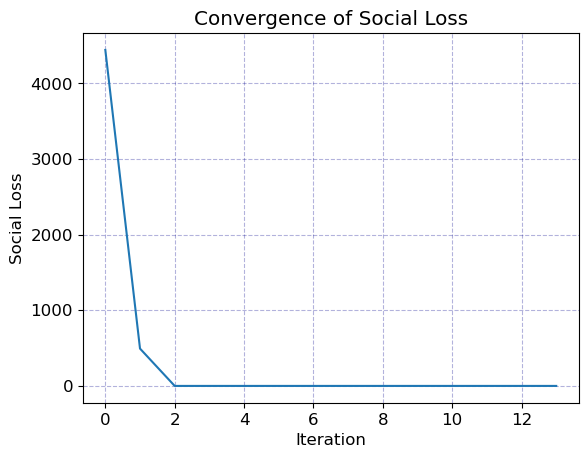

In [88]:
#Defining an empty list to store the social loss values across iterations
social_loss_history = []

#Optimizing with convergence monitoring
def optimization_callback(xk, _):

    #social_loss_val is calculated at each iteration and appendeds it to the social_loss_history list
    social_loss_val = social_loss(xk)
    social_loss_history.append(social_loss_val)
    print("Current social loss:", social_loss_val)

#Optimization using Trust Region Constraint method
#optimal_par_gh minimizes the social_loss function with respect to the parameters [initial_g, initial_alpha_1] 
optimal_par_gh = opt.minimize(social_loss, [initial_g, initial_alpha_1], method='trust-constr', callback=optimization_callback)

#Checking if the social loss has converged by comparing the last two values in social_loss_history
if len(social_loss_history) > 1 and np.isclose(social_loss_history[-1], social_loss_history[-2]):
    print("The optimization has converged.")
else:
    print("The optimization may not have converged.")

#Plotting the convergence of the social loss function
plt.plot(range(len(social_loss_history)), social_loss_history)
plt.xlabel("Iteration")
plt.ylabel("Social Loss")
plt.title("Convergence of Social Loss")
plt.show()

We now check how steady state is affected by monetary policy interventions:

In [89]:
# Create an instance of monetary_policy_intervention class


# Set the desired interest rate for the policy intervention (decrease in interest rate)
interest_rate = -0.2

# Analyze the policy intervention
steady_state_before, steady_state_after = model.analyze_policy_intervention(interest_rate)

# Compare the steady state values
print("Steady state value before policy intervention:", steady_state_before)
print("Steady state value after policy intervention:", steady_state_after)

Steady state value before policy intervention: 67.0
Steady state value after policy intervention: 67.13333333333334


# Further analysis

**Supply shock - Change to s:**
We now examine how supply shocks affect the model in an interactive plot of all the parameters:

In [90]:
# Interactive plot with FloatSlider
interact(plot_supply_shock, s=FloatSlider(min=-2, max=2, step=0.1, value=0), tau=FloatSlider(min=0, max=1, step=0.1, value=0.5))

interactive(children=(FloatSlider(value=0.0, description='s', max=2.0, min=-2.0), IntSlider(value=100, descrip…

<function modelproject.plot_supply_shock(s=0, y_bar=100, pi_star=2, alpha_1=1, alpha_2=1, alpha_3=1, b=1, g=1, g_bar=1, tau=0.5, tau_bar=0.5, h=1, gamma=0.5)>

A positive demand shock (i.e., a negative value of s) moves the AS-curve downwards to the right and represents an unexpected increase in supply. 

If a temporary positive supply shock occurs, pushing the AS-curve downward by the size of the shock, a new short-term equilibrium is achieved. It's observed that inflation decreases, but not entirely due to the shock, as the central bank responds to the lower inflation by easing monetary policy (lowering interest rates), thereby increasing output.

**Demand shock - change to z:**
We now examine how demand shocks affect the model in an interactive plot of all the parameters. The parameter z is given by:
$$
z = \frac{\alpha_1}{1+\alpha_2b}(g_t-\bar{g})-\frac{\alpha_3}{1+\alpha_2b}(\tau_t-\bar{\tau}), \alpha = \frac{\alpha_2 h}{1+\alpha_2b}
$$

In [91]:
interact(plot_demand_shock, s=FloatSlider(min=-2, max=2, step=0.1, value=0), tau=FloatSlider(min=0, max=1, step=0.1, value=0.5))

interactive(children=(FloatSlider(value=0.0, description='s', max=2.0, min=-2.0), IntSlider(value=100, descrip…

<function modelproject.plot_demand_shock(s=0, y_bar=100, pi_star=2, alpha_1=1, alpha_2=1, alpha_3=1, b=1, g=1, g_bar=1, tau=0.5, tau_bar=0.5, h=1, gamma=0.5)>

Demand shocks, z, are caused by changes in taxation, government spending, policy-parameters h and b, and parameter values of the behavioral alphas.

Let's take an increase in government spending h, causing a positive demand shock.

Due to increased demand, the new short-term equilibrium surpasses the long-term equilibrium, resulting in higher output and inflation. This uptick is driven by rising production and employment, which lower the marginal product of labor and increase marginal costs, thereby exerting upward pressure on prices and inflation.

Additionally, domestic inflation doesn't fully reflect the shock, as the central bank responds by tightening monetary policy, raising the policy interest rate by more than 1-to-1 of inflation (according to the Taylor principle). This raises the real interest rate, dampening aggregate demand. (Implicitly affecting the slope of the AD curve).

# Conclusion

In conclusion, this project has examined the impact of shocks on a basic AS/AD model within a closed economy in the short term. Through our analysis, we investigated the repercussions of variations in taxes, government expenditure, and monetary policies.